# Fine Tuning

In [1]:
%matplotlib inline
import d2l
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
import os
import zipfile
npx.set_np()

Downloading a hot dog data set we sampled online. 

In [2]:
data_dir = '../data'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname = gluon.utils.download(
    base_url + 'gluon/dataset/hotdog.zip',
    path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
with zipfile.ZipFile(fname, 'r') as z:
    z.extractall(data_dir)

Loading images with `ImageFolderDataset`.

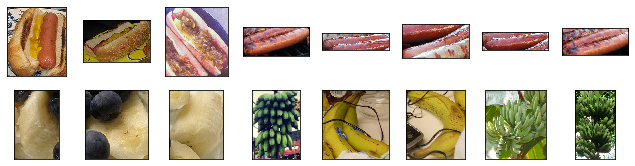

In [3]:
train_imgs = gluon.data.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/train'))
test_imgs = gluon.data.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/test'))

hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

Data preprocessing with image augmentation. 

In [4]:
normalize = gluon.data.vision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomResizedCrop(224),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    normalize])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    normalize])

Defining and initializing the Model.

In [5]:
pretrained_net = gluon.model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.output

Dense(512 -> 1000, linear)

Building the fine-tuning model.

In [6]:
finetune_net = gluon.model_zoo.vision.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# The model parameters in output will be updated using a learning rate ten
# times greater
finetune_net.output.collect_params().setattr('lr_mult', 10)

Training function. 

In [7]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gluon.data.DataLoader(
        train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gluon.data.DataLoader(
        test_imgs.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': 0.001})
    d2l.train_ch12(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

Training.

loss 0.429, train acc 0.899, test acc 0.912
774.5 exampes/sec on [gpu(0), gpu(1)]


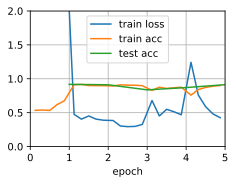

In [8]:
train_fine_tuning(finetune_net, 0.01)

Training from scratch.

loss 0.354, train acc 0.849, test acc 0.868
811.7 exampes/sec on [gpu(0), gpu(1)]


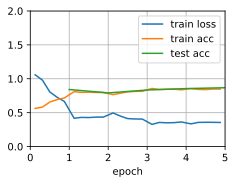

In [9]:
scratch_net = gluon.model_zoo.vision.resnet18_v2(classes=2)
scratch_net.initialize(init=init.Xavier())
train_fine_tuning(scratch_net, 0.1)